In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
# Set to True if want to generate new plot figues at runtime. The plots in README.md file will be updated.
gen_new_plots = False

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

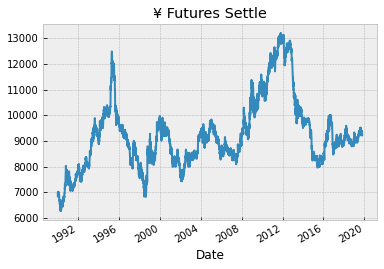

In [5]:
# Plot just the "Settle" column from the dataframe:
yen_futures_settle_fig = yen_futures.Settle.plot(title='¥ Futures Settle').get_figure()
if gen_new_plots: yen_futures_settle_fig.savefig('img/yen_futures_settle_fig.png')

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures.Settle)

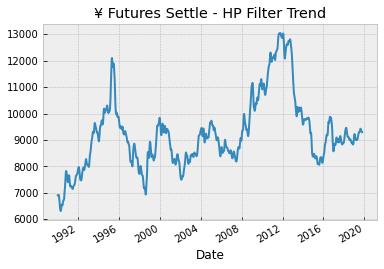

In [7]:
settle_noise_fig = settle_trend.plot(title='¥ Futures Settle - HP Filter Trend').get_figure()
if gen_new_plots: settle_noise_fig.savefig('img/settle_trend_fig_hpfilter.png')

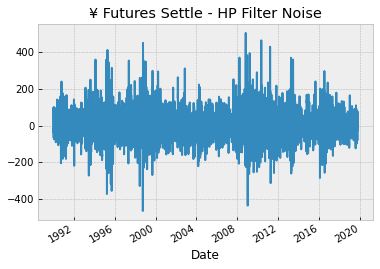

In [8]:
settle_noise_fig = settle_noise.plot(title='¥ Futures Settle - HP Filter Noise').get_figure()
if gen_new_plots: settle_noise_fig.savefig('img/settle_noise_fig_hpfilter.png')

In [9]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
filtered_yen_futures = pd.concat([yen_futures.Settle, settle_noise, settle_trend], axis=1)
filtered_yen_futures.rename(columns={'Settle_cycle' : 'Noise', 'Settle_trend' : 'Trend'}, inplace=True)
filtered_yen_futures.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


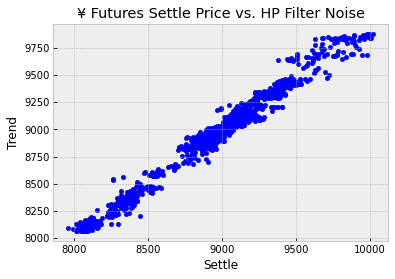

In [10]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle_vs_trend_fig = filtered_yen_futures.loc["2015-01-01":, :].plot.scatter('Settle','Trend', title='¥ Futures Settle Price vs. HP Filter Noise').get_figure()
if gen_new_plots: settle_vs_trend_fig.savefig('img/settle_vs_trend_fig_hpfilter.png')

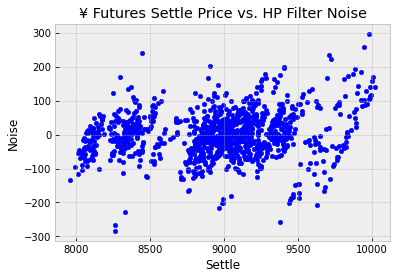

In [11]:
# Plot the Settle Noise
settle_vs_noise_fig = filtered_yen_futures.loc["2015-01-01":, :].plot.scatter('Settle','Noise', title='¥ Futures Settle Price vs. HP Filter Noise').get_figure()
if gen_new_plots: settle_vs_noise_fig.savefig('img/settle_vs_noise_fig_hpfilter.png')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [13]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model = ARMA(returns.Settle, order=(2,1))

# Fit the model and assign it to a variable called results
arma_results = arma_model.fit()

C:\Users\illya\anaconda3\envs\cu_fintech_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
arma_result_summary = arma_results.summary()
arma_result_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 01 Jun 2021   AIC                          15798.142
Time:                        16:38:02   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3351           +0.0000j            3.3351            0.5000
AR.2         -157.1982           +0.0000j          157.1982            0.5000
MA.1           -3.3940           +0.0000j            3.3940            0.5000
-----------------------------------------------------------------------------
"""

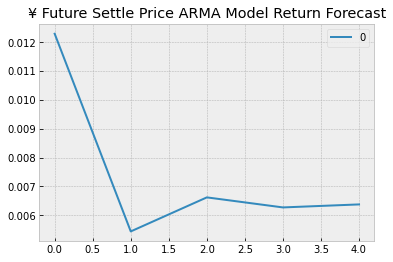

In [15]:
# Plot the 5 Day Returns Forecast
arma_model_5day_fig = pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title="¥ Future Settle Price ARMA Model Return Forecast").get_figure()
if gen_new_plots: arma_model_5day_fig.savefig('img/arma_model_5day_fig.png')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Instantiate the p, d, q vars
p = 5
d = 1
q = 1

arima_model = ARIMA(yen_futures.Settle, order=(p, d, q))

# Fit the model
arima_results = arima_model.fit()

C:\Users\illya\anaconda3\envs\cu_fintech_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\illya\anaconda3\envs\cu_fintech_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
# Output model summary results:
arima_result_summary = arima_results.summary()
arima_result_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 01 Jun 2021   AIC                          83905.238
Time:                        16:38:04   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2824      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3785j            2.3410           -0.1002
AR.2            1.8920           +1.3785j            2.3410            0.1002
AR.3           -2.2713           -3.0195j            3.7784           -0.3526
AR.4           -2.2713           +3.0195j            3.7784            0.3526
AR.5          -11.1153           -0.0000j           11.1153           -0.5000
MA.1            3.3626           +0.0000j            3.3626            0.0000
-----------------------------------------------------------------------------
"""

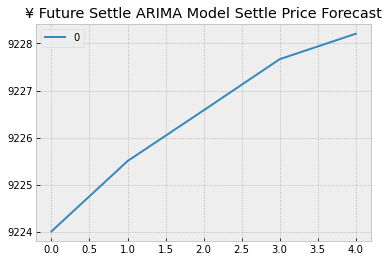

In [18]:
# Plot the 5 Day Price Forecast
arima_model_5day_fig = pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="¥ Future Settle ARIMA Model Settle Price Forecast").get_figure()
if gen_new_plots: arima_model_5day_fig.savefig('img/arima_model_5day_fig.png')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [19]:
from arch import arch_model

In [20]:
# Estimate a GARCH model:
garch_model = arch_model(yen_futures.Settle, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
garch_res = garch_model.fit(disp="off")

In [21]:
# Summarize the model results
garch_res_summary = garch_res.summary()
garch_res_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -79212.8
Distribution:                  Normal   AIC:                           158434.
Method:            Maximum Likelihood   BIC:                           158461.
                                        No. Observations:                 7515
Date:                Tue, Jun 01 2021   Df Residuals:                     7511
Time:                        16:38:04   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.7475e+06  1.135e+05     15.399  1.668e-53  [1.525e+06,1.970e+06]
alpha[1]       0.9762  1.706e-02     57.222      0.000      [  0.943,  1.010]
alpha[2]   2.3745e-03  5.384e-02  4.410e-02      0.965      [ -0.103,  0.108]
beta[1]        0.0000  5.093e-02      0.000      1.000 [-9.982e-02,9.982e-02]
=============================================================================

Covariance estimator: robust
"""

In [22]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [23]:
# Create a 5 day forecast of volatility
garch_forecast_horizon = 5
# Start the forecast using the last_day calculated above
garch_forecasts = garch_res.forecast(start=last_day, horizon=garch_forecast_horizon)
garch_forecasts

In [24]:
# Annualize the forecast
garch_intermediate = np.sqrt(garch_forecasts.variance.dropna() * 252)
garch_intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,146322.255059,146257.600787,146194.306175,146132.339642,146071.673866


In [25]:
# Transpose the forecast so that it is easier to plot
garch_final = garch_intermediate.dropna().T
garch_final.head()

Date,2019-10-15
h.1,146322.255059
h.2,146257.600787
h.3,146194.306175
h.4,146132.339642
h.5,146071.673866


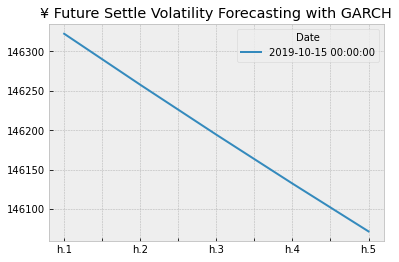

In [26]:
# Plot the final forecast
garch_final_fig = garch_final.plot(title="¥ Future Settle Volatility Forecasting with GARCH").get_figure()
if gen_new_plots: garch_final_fig.savefig('img/garch_5day_fig.png')

---

# Conclusions

## Based on your time series analysis, would you buy the yen now?

According to the ARMA model the future price of Yen Futures is expected to decrease, but according to the ARIMA model the future price difference is expected to increase. Also, according to the GARCG model, volatility is predicted to decrease. Buying yen futures now may yield a loss, as futures markets take advantage of high volatility as well as projected price increase.
I would not be buying the Yen futures now.

## Is the risk of the yen expected to increase or decrease?

The risk according to GARCH model is expected to decrease.

## Based on the model evaluation, would you feel confident in using these models for trading?

Based on these evaluations I would not feel confident trading using these models, as they are incomplete in ragard to number of externalities that can effect the price. Pairing these models with other technical indicators such as RSI, Williams %R, MACD, and Implied Volatility is important. Also, for derivatives market, especially futures market, Open Interest evaluation is an important part of reseach.